<center>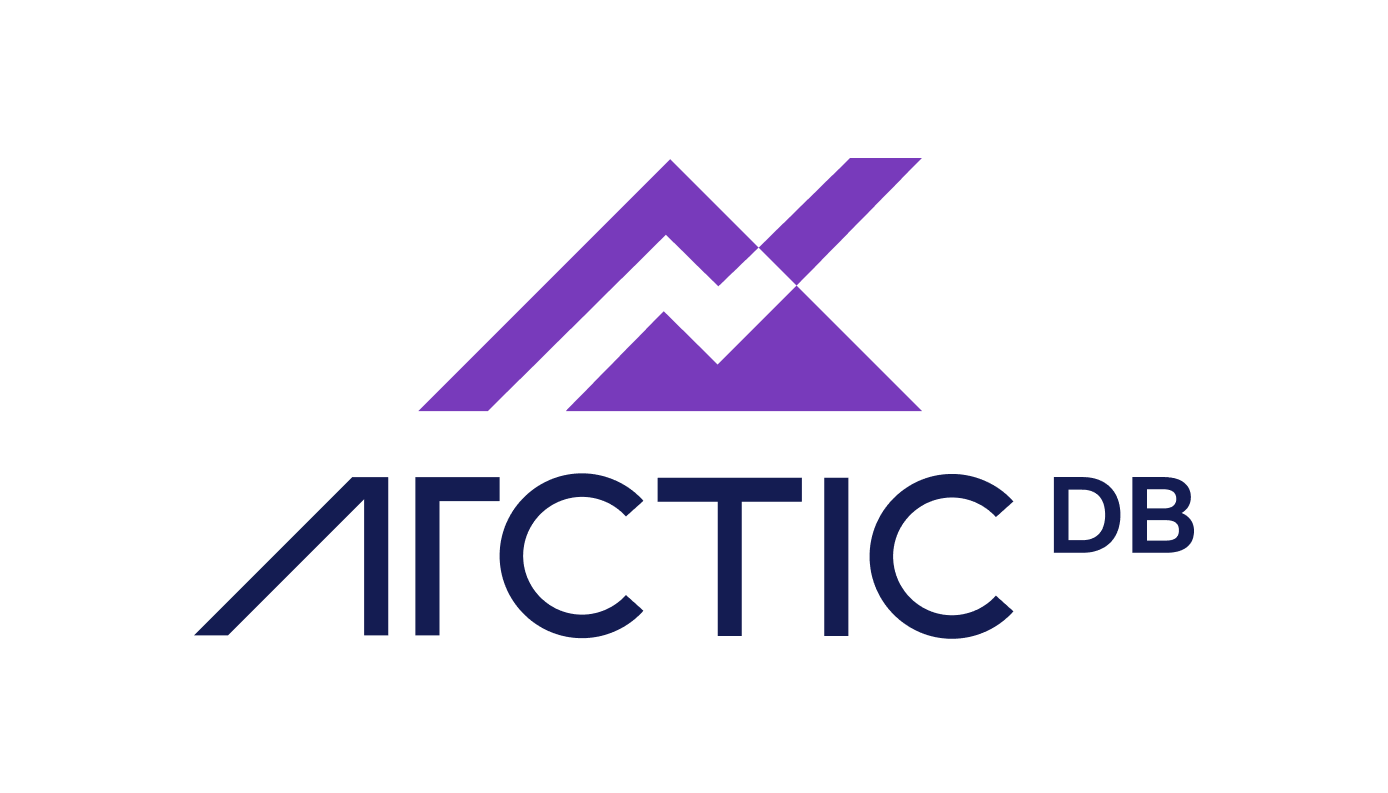
</center>

# ArcticDB Billion Row Challenge Notebook

## Setup
* installs
* imports
* create ArticDB object store
* define the parameters of the problem
* create an ArticDB library to hold the data

In [ ]:
!pip install arcticdb

In [ ]:
from arcticdb.config import set_config_int
set_config_int('VersionStore.NumCPUThreads', 16)

In [ ]:
import pandas as pd
import numpy as np
import arcticdb as adb

In [3]:
arctic = adb.Arctic("lmdb://arcticdb_brc")

In [ ]:
sym_1brc = 'weather_stations_1brc'
num_cities = 10_000
num_rows = 1_000_000_000
aggs = {
    'max': ('Temperature', 'max'), 
    'min': ('Temperature', 'min'),
    'mean': ('Temperature', 'mean')
}
num_blocks = 16
block_size = num_rows // num_blocks
seed = 17
cities = np.array([f"city_{i:04d}" for i in range(num_cities)])
print(f"block_size: {block_size:,d}, total records: {block_size*num_blocks:,d}")

In [17]:
lib_name = 'arcticdb_brc'
# delete the library if it already exists
arctic.delete_library(lib_name)
# performance tuning: a large rows_per_segment value can improve performance for dataframes with a large number of rows
lib_options = adb.LibraryOptions(rows_per_segment=10_000_000)
lib = arctic.get_library(lib_name, create_if_missing=True, library_options=lib_options)

## Write the Data to ArcticDB
* Generate the data: each row has a city chosen at random from the list and a random temperature between -99.9 and 99.9
* Data is written in blocks to control memory usage

In [18]:
def create_block_df(rng, cities, block_size):
    random_cities = rng.choice(cities, size=block_size)
    random_temperatures = np.round(rng.uniform(-99.9, 99.9, size=block_size), 4)
    return pd.DataFrame({'City': random_cities, 'Temperature': random_temperatures})

In [ ]:
rng = np.random.default_rng(seed)
print('Writing blocks: ', end='')
for b in range(num_blocks):
    block_df = create_block_df(rng, cities, block_size)
    if b==0:
        lib.write(sym_1brc, block_df)
    else:
        lib.append(sym_1brc, block_df, validate_index=False)
    print(f'{b}, ', end='')
print(' Finished')

## Read and Aggregate the Data
* Uses the DataFrame processing operations in ArcticDb to group and aggregate the data
* This allows the performant multi-threaded C++ layer to do the heavy lifting
* This code uses too much memory to run on the free Google colab. The chunked version below will work

In [20]:
%%timeit
# this runs the query several times to get an accurate timing
lazy_df = lib.read(sym_1brc, lazy=True)
lazy_df.groupby('City').agg(aggs)
lazy_df.collect()

7.01 s ± 604 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
# run the query once more to see the output
lib.read(sym_1brc, lazy=True).groupby('City').agg(aggs).collect().data.sort_index().round(1)

min  mean   max
City                       
city_0000 -99.9   0.0  99.8
city_0001 -99.9   0.2  99.9
city_0002 -99.7   0.2  99.9
city_0003 -99.9   0.1  99.9
city_0004 -99.8  -0.2  99.9
...         ...   ...   ...
city_9995 -99.9  -0.4  99.9
city_9996 -99.9   0.1  99.9
city_9997 -99.9   0.7  99.9
city_9998 -99.9  -1.3  99.9
city_9999 -99.8  -0.2  99.9

[10000 rows x 3 columns]

## Conclusions
* It was easy to solve the 1 billion row challenge using ArticDB
* The code is short and easy to read
* Almost no tuning was needed to get good performance

## Bonus: Chunked Read and Aggregate
* This version reads and aggregates in chunks
* It has the same end result as the simpler version above
* It performs almost as well and needs less memory
* In particular, it will run within the memory on the free version of Google colab

In [23]:
# we need to aggregate sum and count to get the aggregated mean
aggs_chunked = {
    'max': ('Temperature', 'max'), 
    'min': ('Temperature', 'min'),
    'sum': ('Temperature', 'sum'),
    'count': ('Temperature', 'count')
}

# define a list of ReadRequests - the chunks are based on row_ranges
read_requests = [adb.ReadRequest(symbol=sym_1brc, 
                                 row_range=(block_size*b, block_size*(b+1)))
                 for b in range(num_blocks)
                ]

In [24]:
# these functions merge the results of the chunks into one result
def merge_results_pair(r0, r1):
    join_r = r0.join(r1, lsuffix='_0', rsuffix='_1')
    return pd.DataFrame(index=join_r.index,
                        data={
                            'min': join_r[['min_0', 'min_1']].min(axis=1),
                            'max': join_r[['max_0', 'max_1']].max(axis=1),
                            'count': join_r[['count_0', 'count_1']].sum(axis=1),
                            'sum': join_r[['sum_0', 'sum_1']].sum(axis=1),
                        }
                       )

def merge_results(r):
    res = r[0].data.sort_index()
    for b in range(1, len(r)):
        next_res = r[b].data.sort_index()
        res = merge_results_pair(res, next_res)
    res['mean'] = res['sum'] / res['count']
    res = res.drop(columns=['sum', 'count']).loc[:, ['min', 'mean', 'max']].round(1)
    return res

In [25]:
lazy_df_collection = lib.read_batch(read_requests, lazy=True)
# Apply the same processing to each chunk
lazy_df_collection.groupby('City').agg(aggs_chunked)
read_results = lazy_df_collection.collect()
results = merge_results(read_results)
results

min  mean   max
City                       
city_0000 -99.9   0.0  99.8
city_0001 -99.9   0.2  99.9
city_0002 -99.7   0.2  99.9
city_0003 -99.9   0.1  99.9
city_0004 -99.8  -0.2  99.9
...         ...   ...   ...
city_9995 -99.9  -0.4  99.9
city_9996 -99.9   0.1  99.9
city_9997 -99.9   0.7  99.9
city_9998 -99.9  -1.3  99.9
city_9999 -99.8  -0.2  99.9

[10000 rows x 3 columns]